# Dados abertos e Ciência de Dados: a aprovação do Orçamento de Estado de 2021 através de dados abertos.

* Github: 👉 https://github.com/fsmunoz/pt-act-parlamentar/blob/master/OE2021.ipynb
* Jupyter Viewer: 👉 https://nbviewer.jupyter.org/github/fsmunoz/pt-act-parlamentar/raw/master/OE2021.ipynb
* PowerBI app: 👉 https://app.powerbi.com/view?r=eyJrIjoiODJjYzA4YTMtNGJhYi00ZTlhLTlkN2EtNDQ1ODFlZGI3ZWQ5IiwidCI6IjBiZmE4NTAwLWIxZjItNDU2Ni1iYWYxLTZmNTkzNzA4OTNlNyIsImMiOjh9
* Airtable 👉 https://airtable.com/shrrp72RkA993AlfG

## Introdução

*Este bloco de notas é um trabalho ao trabalho inicial que pode ser acedido em 👉 https://nbviewer.jupyter.org/github/fsmunoz/pt-act-parlamentar/raw/master/Actividade%20Parlamentar%20da%20XIV%20Legislatura.ipynb, e que descreve de forma detalhada todas as opções, com visibilidade de todo o código, explicação dos algoritmos utilizados e todo o processo de tratamento e exploração de dados; esta actualiação concentrar-se nos resultados e assume que quem deseja conhecer em maior detalhe os algoritmos irá consultar o trabalho original.*

*O resultado dos tratamento de dados e a listagem das votações é também disponibilização, para maior facilidade de análise independente, na "vista" de Airtable indicada acima.

A análise das votações e posicionamento relativo dos partidos tendo como base *exclusivamente* a forma como votam foi a base do trabalho anterior, análise essa que teve como fonte as votações das Iniciativas e Actividades.

O Orçamento de Estado para 2021 foi um acontecimento marcante da realidade política nacional do último trimestre de 2020 e que continuará a ter impactos na apreciação e debate político no futuro próximo: a posição dos vários partidos em termos de viabilização ou não do OE, as propostas que apresentaram e quem as aprovou ou recusou são matéria utilizada no debate para as Presidenciais, por exemplo.

Estas votações não estão incluídas na análise anterior: os dados utilizados relativs a votações no Parlamento não incluem, por exemplo, as votações feitas em Comissões. Esta actualização aborda um conjunto de votações independente, muito mais circunscrito no tempo e (dentro da grande variedade de temas abordados no OE) no conteúdo.

## Metodologia

Com base nos dados disponibilizados pela Assembleia da República em formato XML [DadosAbertos] são criadas _dataframes_ (tabelas de duas dimensões) com base na selecção de informação relativa aos padrões de votação de cada partido (e/ou deputados não-inscritos)

São fundamentalmente feitas as seguintes análises:

1. Quantidade e tipo de propostas feitas, e resultado das mesmas
2. Apoio para as propostas de cada partido
2. Matriz de distância entre todos os partidos e dendograma
3. Identificação de grupos (_spectral clustering_) e visualização das distâncias num espaço cartesiano (_multidimensional scaling_)

## Obtenção e tratamento dos dados

Esta fase é fundamental para toda a restante análise: é onde obtemos os dados e os transformamos em informação num formato que pode ser facilmente manipulado.

In [1]:
!pip3 install --user -q  matplotlib pandas seaborn sklearn

%matplotlib notebook

## Obtenção do ficheiro e conversão para dataframe

Os dados do OE encontram-se num ficheiro XML disponibilização na página do Parlamento:

In [2]:
from urllib.request import urlopen
import xml.etree.ElementTree as ET

oe_url = "http://app.parlamento.pt/webutils/docs/doc.xml?path=6148523063446f764c324679626d56304c3239775a57356b595852684c3052685a47397a51574a6c636e52766379395063734f6e5957316c626e52764a5449775a47386c4d6a4246633352685a47387657456c574a5449775447566e61584e7359585231636d457654305651636d397762334e3059584e426248526c636d466a595738794d4449785433497565473173&fich=OEPropostasAlteracao2021Or.xml&Inline=true"
oe_tree = ET.parse(urlopen(oe_url))

## Propostas de alteração

Esse ficheiro contém a informação das proposts de alteração, votações e outros detalhes, dos quais extraímos alguns campos que consideramos essenciais para a análise; numa primeira fase obtemos os resultados das Propostas (e não das votações individuais que as compõe, como veremos mais à frente):

In [3]:
import collections

counter=0
vc=0
## We will build a dataframe from a list of dicts
## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
oe_list = []

for alter in oe_tree.findall(".//PropostaDeAlteracao"):
    votep = alter.find('./Votacoes')
    if votep is not None:
        oe_dict = collections.OrderedDict()
        counter +=1
        oe_dict["ID"]=alter.find('./ID').text
        oe_dict["Nr"]=alter.find('./Numero').text
        oe_dict["Date"]=alter.find('./Data').text
        oe_dict["Domain"]=alter.find('./Tema').text
        oe_dict["Type"]=alter.find('./Tipo').text
        oe_dict["State"]=alter.find('./Estado').text
        oe_dict["GP"]=alter.find('./GrupoParlamentar_Partido').text
        init_title=alter.find('./Iniciativas_Artigos/Iniciativa_Artigo/Titulo')
        if init_title is not None:
            oe_dict["IniTitle"]=init_title.text
        #oe_list.append(oe_dict)
        for vote in alter.findall("./Votacoes/"):
            vc +=1
            for vote_el in vote:
                if vote_el.tag == "Data":
                    oe_dict["V_Date"] = vote_el.text
                    # print(oe_dict["ID"])
                if vote_el.tag == "Descricoes":
                    descp = vote_el.find('./Descricao')
                    if descp is not None: 
                        oe_dict["VoteDesc"] = vote_el.find('./Descricao').text
                if vote_el.tag == "Resultado":
                    oe_dict["Result"] = vote_el.text
                for gps in vote.findall("./GruposParlamentares/"):
                    if gps.tag == "GrupoParlamentar":
                        gp = gps.text
                    else:
                        oe_dict[gp] = gps.text

        oe_list.append(oe_dict)
    print('.', end='')
        
print("\nProposals:",counter)
print(vc)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Os dados são convertidos num *dataframe* pandas:

In [4]:
import pandas as pd

oe_df = pd.DataFrame(oe_list)
oe_df

,ID,Nr,Date,Domain,Type,State,GP,IniTitle,VoteDesc,Partido Socialista,...,Pessoas-Animais-Natureza,Chega,Iniciativa Liberal,V_Date,Result,Livre,"Partido Ecologista ""Os Verdes""",CRISTINA RODRIGUES(Ninsc),JOACINE KATAR MOREIRA(Ninsc),SARA MADRUGA DA COSTA(PSD)
0,14658,1440C,13/11/2020 20:08:00,Orçamento e Finanças,Aditamento (Números e Alíneas),Aprovado(a) em Comissão,PS,Investimento em infraestruturas de habitação p...,"N.º 3, Artigo 150.º",Favor,...,Favor,Abstenção,Abstenção,23/11/2020 00:00:00,Aprovado(a),NaN,NaN,NaN,NaN,NaN
1,14656,1439C,13/11/2020 19:59:00,Cultura e Comunicação,Por Definir,Retirado(a),PCP,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,14655,1438C,13/11/2020 19:59:00,"Educação, Ciência, Juventude e Desporto",Aditamento (Artigo PPL),Aprovado(a) Parcialmente em Comissão,PCP,Programa de apoio ao trabalho artístico e cult...,Artigo 171.º-A,Favor,...,Favor,Favor,Contra,25/11/2020 00:00:00,Aprovado(a),NaN,NaN,NaN,NaN,NaN
3,14654,1437C,13/11/2020 19:59:00,Orçamento e Finanças,Aditamento (Artigo PPL),Rejeitado(a) em Comissão,PCP,Devolução de verbas do Fundo de Garantia Autom...,Artigo 207.º-A,Contra,...,Contra,Abstenção,Contra,24/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
4,14653,1436C,13/11/2020 19:58:00,Negócios Estrangeiros e Comunidades Portuguesas,Aditamento (Artigo PPL),Rejeitado(a) em Comissão,PCP,Apoio às associações portuguesas no estrangeiro,Artigo 30.º-A,Contra,...,Favor,Favor,Contra,20/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1542,13152,5C,29/10/2020 09:02:00,Centro de recolha de animais,Emenda,Rejeitado(a) em Comissão,CRISTINA RODRIGUES,"Centros de recolha oficial de animais, apoio à...","N.º 1, Artigo 211.º",Contra,...,Favor,Favor,Favor,24/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
1543,13151,4C,29/10/2020 09:02:00,"Ambiente, Energia e Ordenamento do Território",Aditamento (Artigo PPL),Aprovado(a) em Comissão,PEV,Avaliação ambiental estratégica para aferir me...,Artigo 196.º-A,Contra,...,Favor,Favor,Favor,24/11/2020 00:00:00,Aprovado(a),NaN,NaN,NaN,NaN,NaN
1544,13150,3C,29/10/2020 09:01:00,Creches,Aditamento (Números e Alíneas),Rejeitado(a) em Comissão,PCP,Gratuitidade de creche,"N.º 7, Artigo 114.º",Contra,...,Favor,Abstenção,Contra,20/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
1545,13149,2C,29/10/2020 09:01:00,"Administração Pública, Modernização Administra...",Substituição,Aprovado(a) em Comissão,PCP,Reforço de dotação do pessoal não docente na e...,Artigo 174.º,Favor,...,Favor,Favor,Contra,23/11/2020 00:00:00,Aprovado(a),NaN,NaN,NaN,NaN,NaN


Esta informação permite-nos desde já determinar a origem das propostas de alteração:

In [5]:
oe_df.groupby('GP')[['ID']].count().sort_values("ID", ascending=False)

,ID
GP,
PCP,352
PAN,266
CH,157
PEV,123
IL,115
CDS-PP,114
PSD,104
CRISTINA RODRIGUES,101
PS,79


E em gráfico de barras:

In [6]:

oe_df.groupby('GP')[['ID']].count().sort_values(by=['ID'], axis=0, ascending=False).plot(kind="bar",stacked=True,figsize=(6,6))



<IPython.core.display.Javascript object>

A quantidade total de propostas está em linha com os dados publicados ("Os partidos que viabilizaram o OE 2021, sem contar com o PS, entregaram 58% das propostas de alteração, com um total de 898 medidas. O PCP, que é decisivo na votação final, é o que mais quer mudar OE", https://eco.sapo.pt/2020/11/20/58-das-propostas-para-alterar-oe-2021-sao-dos-que-o-viabilizaram/).

Sabemos a quantidade total de propostas, mas quais foram aprovadas? Esta tabela indica os resultados das propostas de todos os partidos e deputados:

In [7]:
pd.crosstab(oe_df.GP, oe_df.State).columns

ct = pd.crosstab(oe_df.GP, oe_df.State)[['Aprovado(a) por Unanimidade em Plenário',
                                         'Aprovado(a) por Unanimidade em Comissão',
                                         'Aprovado(a) em Plenário',
                                         'Aprovado(a) em Comissão',
                                         'Aprovado(a) Parcialmente em Plenário',
                                         'Aprovado(a) Parcialmente em Comissão',
                                         'Entrada (via IPA)',
                                         'Aguarda Voto em Comissão',
                                         'Retirado(a)',
                                         'Prejudicado(a)',
                                         'Rejeitado(a) em Plenário',
                                         'Rejeitado(a) em Comissão'
                                        ]]
ct

State,Aprovado(a) por Unanimidade em Plenário,Aprovado(a) por Unanimidade em Comissão,Aprovado(a) em Plenário,Aprovado(a) em Comissão,Aprovado(a) Parcialmente em Plenário,Aprovado(a) Parcialmente em Comissão,Entrada (via IPA),Aguarda Voto em Comissão,Retirado(a),Prejudicado(a),Rejeitado(a) em Plenário,Rejeitado(a) em Comissão
GP,,,,,,,,,,,,
BE,0,0,1,0,0,0,0,0,0,0,9,2
CDS-PP,0,0,0,6,0,1,0,0,2,1,2,102
CH,0,0,0,0,0,0,0,0,13,0,5,139
CRISTINA RODRIGUES,0,0,0,8,0,1,0,1,0,0,0,91
IL,0,0,2,0,0,0,0,0,0,0,0,113
JOACINE KATAR MOREIRA,0,0,0,11,0,0,0,0,0,1,0,48
PAN,0,0,0,45,0,5,0,0,14,0,8,194
"PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES",0,0,0,8,0,0,0,0,0,0,0,56
PCP,0,1,0,61,2,11,1,1,6,0,6,263


A mesma informação em forma de gráfico de barras: o total de propostas de cada partido (ou deputados) com a distribuição do resultado das mesmas, ordenados pelo maior número de aprovações.

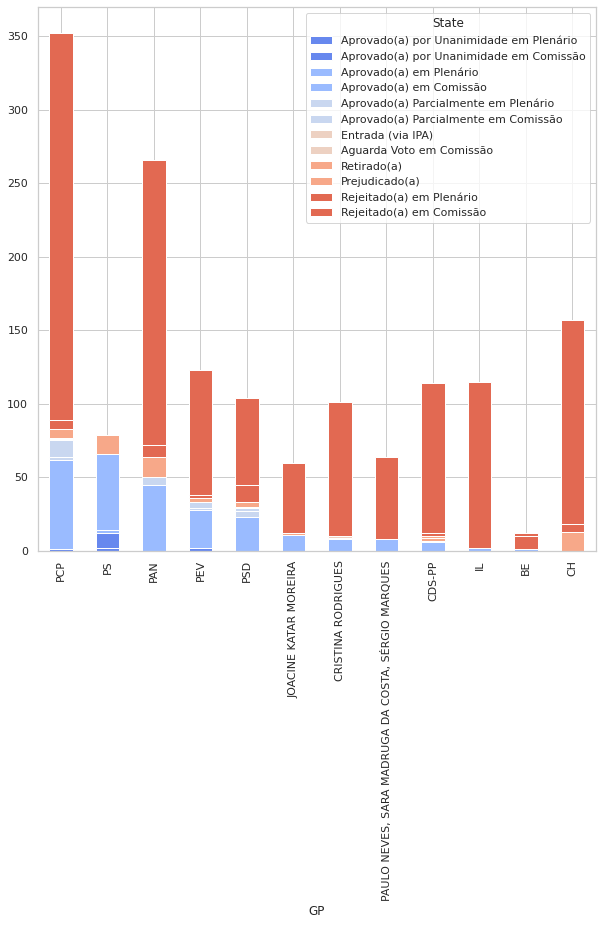

In [8]:
%matplotlib inline
#    sp = sp.sort_values(by=['Favor','Abstenção','Contra'], ascending=False, axis=1)
import seaborn as sns
from matplotlib.colors import ListedColormap

sns.set()
sns.set_style("whitegrid")

## Sort by the "Approved in Comission" since this is >95% of the approved group and simplifies having to
## sort by a separate aggregate value.
ct.sort_values(by=['Aprovado(a) em Comissão', 'Aprovado(a) em Plenário','Aprovado(a) Parcialmente em Comissão','Aprovado(a) Parcialmente em Plenário','Aprovado(a) por Unanimidade em Comissão','Aprovado(a) por Unanimidade em Plenário'], ascending=False,axis=0).plot(kind="bar", stacked=True, colormap=ListedColormap(sns.color_palette("coolwarm").as_hex()),figsize=(10,10))


Algumas das leituras que se podem tirar desdes dados: 

* O maior número de propostas submetidas, rejeitadas mas também aprovadas é do PCP.
* O PS é o que tem uma percentagem de aprovação maior.
* CH não tem nenhuma. 
* Os restantes partidos e deputados têm a maioria das suas propostas rejeitadas e, em diferente número (BE tem 1 alteração aprovada), algumas aprovadas.

Estes resultados podem ser relacionados com o que foi a viabilização do OE: de facto os 4 primeiros partidos por número de alterações aprovadas são os que participaram na viabilização ("PS, PCP, PAN e PEV viabilizam OE 2021. BE e direita votam contra", https://eco.sapo.pt/2020/10/28/ps-pcp-pan-e-pev-viabilizam-oe-2021-be-e-direita-votam-contra/), sendo legítimo considerar que esse facto está directamente relacionado.

E que propostas cada partido conseguiu aprovar? A utilização do título da iniciativa é aqui útil

In [9]:
from IPython.display import display, HTML

approved_oe = oe_df[oe_df.State.str.contains("Aprovado")].fillna("")

for gp in approved_oe.GP.unique():
    gp_df = approved_oe[approved_oe["GP"]==gp][["GP","IniTitle", "VoteDesc", "State"]]
    print(gp + ": ", len(gp_df.index), " proposals approved:")
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1):  # more options can be specified also
        display(gp_df)



PS:  66  proposals approved:


,GP,IniTitle,VoteDesc,State
0,PS,Investimento em infraestruturas de habitação para profissionais das forças de segurança,"N.º 3, Artigo 150.º",Aprovado(a) em Comissão
134,PS,Menores Refugiados Não Acompanhados,Artigo 144.º-A,Aprovado(a) por Unanimidade em Comissão
166,PS,Alteração ao regime geral da gestão de resíduos e ao regime da contribuição extraordinária sobre o setor energético,Artigo 201.º-A,Aprovado(a) em Comissão
190,PS,Alteração ao Código do Imposto sobre Veículos,Artigo 238.º,Aprovado(a) em Comissão
191,PS,Alteração ao Código do Imposto sobre Veículos,Artigo 238.º,Aprovado(a) em Comissão
194,PS,"Interconexão de dados entre a Agência para o desenvolvimento e Coesão, I.P (AD&C) e a Autoridade Tributária e Aduaneira (AT)",Artigo 218.º-A,Aprovado(a) em Comissão
202,PS,Norma interpretativa em sede de IRS,Artigo 220.º-A,Aprovado(a) em Comissão
205,PS,Alteração ao Código do Imposto sobre o Rendimento das Pessoas Singulares,Artigo 220.º,Aprovado(a) em Comissão
210,PS,Alteração ao Código Fiscal do Investimento,Artigo 247.º,Aprovado(a) em Comissão
223,PS,Regime transitório no âmbito do IRS,"N.º 2, Artigo 222.º",Aprovado(a) em Comissão


PCP:  75  proposals approved:


,GP,IniTitle,VoteDesc,State
2,PCP,Programa de apoio ao trabalho artístico e cultural,Artigo 171.º-A,Aprovado(a) Parcialmente em Comissão
13,PCP,Revisão do protocolo com o INEM e a ANEPC,Artigo 149.º-A,Aprovado(a) em Comissão
14,PCP,Internalização de Meios Complementares de Diagnóstico e Terapêutica,Artigo 183.º-A,Aprovado(a) Parcialmente em Comissão
17,PCP,Rendas de imóveis em centros comerciais,Artigo 139.º-A,Aprovado(a) Parcialmente em Plenário
21,PCP,Regime excecional de pagamento das rendas,Artigo 139.º-A,Aprovado(a) Parcialmente em Comissão
22,PCP,Garantia dos salários por inteiro,Artigo 136.º-A,Aprovado(a) em Comissão
36,PCP,Outras disposições no âmbito do Imposto sobre o Valor Acrescentado,"N.º 2, Artigo 229.º",Aprovado(a) em Comissão
37,PCP,Plano Plurianual de Investimento na Investigação Criminal,Artigo 28.º-A,Aprovado(a) em Comissão
48,PCP,Transferências orçamentais,"34-A, Mapa de alterações e transferências orçamentais, Artigo 7.º",Aprovado(a) em Comissão
61,PCP,"Alteração à Lei n.º 10/2014, de 6 de março, que aprova os Estatutos da Entidade Reguladora dos Serviços de Águas e Resíduos e ao Decreto-Lei n.º 96/2014, de 25 de junho, que estabelece o regime jurídico da concessão da exploração e da",Artigo 265.º-A,Aprovado(a) em Comissão


PAN:  50  proposals approved:


,GP,IniTitle,VoteDesc,State
18,PAN,"Dinamização do Registo Nacional de Profissionais do Sector das Atividades Artísticas, Culturais e de Espetáculo",Artigo 171.º-A,Aprovado(a) em Comissão
27,PAN,Levantamento exaustivo do tecido cultural existente,Artigo 171.º-B,Aprovado(a) em Comissão
53,PAN,Transição de saldos da Lusa,Artigo 168.º-A,Aprovado(a) em Comissão
96,PAN,"Contribuição sobre as embalagens de plástico, alumínio ou multimaterial com plástico ou com alumínio de utilização única adquiridas em refeições prontas a consumir, nos regimes de pronto a comer e levar ou com entrega ao domicílio, a aplicar-se a par",Artigo 154.º-A,Aprovado(a) em Comissão
103,PAN,Alteração ao Código do Imposto sobre Veículos,Artigo 238.º,Aprovado(a) em Comissão
104,PAN,Alteração ao Código do Imposto sobre o Rendimento das Pessoas Coletivas,Artigo 226.º,Aprovado(a) em Comissão
247,PAN,Regulamentação da profissão dos intérpretes de língua gestual,Artigo 39.º-A,Aprovado(a) em Comissão
266,PAN,Alteração ao Código dos Impostos Especiais de Consumo,Artigo 234.º,Aprovado(a) em Comissão
267,PAN,Alteração ao Código dos Impostos Especiais de Consumo,Artigo 234.º,Aprovado(a) em Comissão
285,PAN,Elaboração de estudo nacional sobre o impacto da distância percorrida pelos alimentos importados desde a sua produção ao consumo,Artigo 157.º-B,Aprovado(a) em Comissão


PSD:  29  proposals approved:


,GP,IniTitle,VoteDesc,State
42,PSD,Isenção dos emolumentos e outros encargos registais,Artigo 219.º-D,Aprovado(a) em Comissão
57,PSD,Apoio ao Património da Fundação Mata do Bussaco,Artigo 262.º-A,Aprovado(a) em Comissão
70,PSD,Alargamento do prazo de adesão à moratória de crédito,Artigo 219.º-C,Aprovado(a) em Comissão
85,PSD,Certidão comprovativa de situação contributiva regularizada,Artigo 261.º-B,Aprovado(a) em Comissão
86,PSD,Emissão certidão comprovativa de situação tributária,Artigo 261.º-A,Aprovado(a) em Comissão
140,PSD,"Resgate de PPR, de PPE ou de PPR/E sem penalização",Artigo 219.º-A,Aprovado(a) em Comissão
197,PSD,Fundo Resultante do Trespasse da Concessão das Barragens,Artigo 98.º-A,Aprovado(a) Parcialmente em Comissão
214,PSD,Alteração ao Código dos Impostos Especiais de Consumo,Artigo 234.º,Aprovado(a) em Comissão
240,PSD,Alteração à lei-quadro das entidades reguladoras,Artigo 263.º-B,Aprovado(a) em Comissão
241,PSD,Valor reforçado,"N.º 3, Artigo 2.º",Aprovado(a) em Comissão


PEV:  33  proposals approved:


,GP,IniTitle,VoteDesc,State
106,PEV,"Realização de Avaliação Ambiental Estratégica de Mineração com especial ênfase sobre a prospeção, pesquisa e exploração de depósitos minerais de lítio e minerais associados",Artigo 199.º-G,Aprovado(a) Parcialmente em Comissão
165,PEV,Projetos sobre o Impacto da Poluição Luminosa no Ambiente,Artigo 198.º-B,Aprovado(a) em Comissão
391,PEV,Alteração ao Código do Imposto Municipal sobre as Transmissões Onerosas de Imóveis,Artigo 240.º,Aprovado(a) em Comissão
392,PEV,Alteração ao Código do Imposto Municipal sobre as Transmissões Onerosas de Imóveis,Artigo 240.º,Aprovado(a) em Comissão
396,PEV,Alteração ao Código do Imposto Municipal sobre Imóveis,Artigo 239.º,Aprovado(a) em Comissão
674,PEV,Estudo e substituição dos sistemas energéticos das escolas por outros mais sustentáveis,Artigo 198.º-A,Aprovado(a) em Comissão
774,PEV,Processo de construção da Escola Superior de Saúde do Instituto Politécnico de Setúbal,Artigo 172.º-A,Aprovado(a) em Comissão
817,PEV,Incentivo à investigação do património cultural,"N.º 2, Artigo 170.º",Aprovado(a) em Comissão
825,PEV,Avaliação e reformulação dos apoios públicos às centrais a biomassa florestal,Artigo 155.º-C,Aprovado(a) em Comissão
830,PEV,Recuperação do Pinhal de Leiria,Artigo 155.º-A,Aprovado(a) Parcialmente em Plenário


CDS-PP:  7  proposals approved:


,GP,IniTitle,VoteDesc,State
320,CDS-PP,Recrutamento de trabalhadores nas instituições de ensino superior públicas,"N.º 7, Artigo 37.º",Aprovado(a) em Comissão
327,CDS-PP,Monitorização do abandono escolar e da ação social no Ensino Superior,Artigo 176.º-A,Aprovado(a) em Comissão
343,CDS-PP,Majoração do montante do subsídio de desemprego e do subsídio por cessação de atividade,"Epígrafe, Artigo 113.º",Aprovado(a) em Comissão
413,CDS-PP,Taxa Municipal de Direitos de Passagem e a Taxa Municipal de Ocupação de Subsolo,Artigo 240.º-A,Aprovado(a) em Comissão
454,CDS-PP,Regime excecional das redes de faixas de gestão de combustível,"N.º 18, Artigo 155.º",Aprovado(a) Parcialmente em Comissão
618,CDS-PP,"Contagem da avaliação obtida pelos ex-militares, nos anos em que desempenharam funções nas Forças Armadas, após ingresso na Administração Pública",Artigo 17.º-A,Aprovado(a) em Comissão
652,CDS-PP,"Alteração à Lei n.º 10/2017, de 3 de março",Artigo 265.º-C,Aprovado(a) em Comissão


IL:  2  proposals approved:


,GP,IniTitle,VoteDesc,State
528,IL,Objeto,"Alínea d), N.º 1, Artigo 1.º",Aprovado(a) em Plenário
1331,IL,Portal da transparência do processo de execução dos fundos europeus,Artigo 175.º-A,Aprovado(a) em Plenário


PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES:  8  proposals approved:


,GP,IniTitle,VoteDesc,State
766,"PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES",Centro de Produção da RTP-Madeira,Artigo 161.º-B,Aprovado(a) em Comissão
768,"PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES",Plano de remodelação e construção de novas esquadras da Polícia de Segurança Pública na Região Autónoma da Madeira,Artigo 161.º-A,Aprovado(a) em Comissão
776,"PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES",Reforço dos meios de combate a incêndios e de apoio às populações na Região Autónoma da Madeira,"N.º 2, Artigo 153.º",Aprovado(a) em Comissão
785,"PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES",Redução de taxas aeroportuárias nos aeroportos da Madeira e do Porto Santo,Artigo 66.º-A,Aprovado(a) em Comissão
786,"PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES",Cooperação Financeira entre o Estado e a Região Autónoma da Madeira com vista à concretização da Estratégia Regional de Habitação,Artigo 69.º-A,Aprovado(a) em Comissão
787,"PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES",Alteração à Lista I anexa ao Código do IVA,Artigo 228.º-B,Aprovado(a) em Comissão
802,"PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES",Instituições públicas de ensino superior das regiões autónomas,Artigo 172.º-B,Aprovado(a) em Comissão
806,"PAULO NEVES, SARA MADRUGA DA COSTA, SÉRGIO MARQUES",Subsídio de mobilidade social,Artigo 68.º-A,Aprovado(a) em Comissão


JOACINE KATAR MOREIRA:  11  proposals approved:


,GP,IniTitle,VoteDesc,State
856,JOACINE KATAR MOREIRA,Estratégia Nacional para a Agricultura Biológica e Plano de Ação 2017-27,Artigo 205.º-A,Aprovado(a) em Comissão
1292,JOACINE KATAR MOREIRA,Campanha Nacional contra o abandono animal e de promoção da adoção consciente,Artigo 212.º-A,Aprovado(a) em Comissão
1390,JOACINE KATAR MOREIRA,Inventariação de produtos que tenham na sua génese trabalho infantil ou trabalho forçado,Artigo 145.º-A,Aprovado(a) em Comissão
1391,JOACINE KATAR MOREIRA,Execução de fundos na área da floresta,Artigo 157.º-A,Aprovado(a) em Comissão
1406,JOACINE KATAR MOREIRA,Alteração ao Estatuto dos Benefícios Fiscais,Artigo 242.º,Aprovado(a) em Comissão
1415,JOACINE KATAR MOREIRA,Regulamentação da Lei Orgânica e do Estatuto de Pessoal da Polícia Judiciária,Artigo 35.º-A,Aprovado(a) em Comissão
1421,JOACINE KATAR MOREIRA,Plano nacional para a inclusão digital,Artigo 25.º-A,Aprovado(a) em Comissão
1424,JOACINE KATAR MOREIRA,Implementação do Plano Plurianual de Investimentos para o Serviço Nacional de Saúde e do Plano Nacional de Saúde Mental,"N.º 3, Artigo 183.º",Aprovado(a) em Comissão
1429,JOACINE KATAR MOREIRA,"Observatório Independente do Discurso de Ódio, Racismo e Xenofobia",Artigo 46.º-A,Aprovado(a) em Comissão
1443,JOACINE KATAR MOREIRA,Estratégia Nacional para a Integração das Pessoas em Situação de Sem-Abrigo 2017-2023,"N.º 4, Artigo 99.º",Aprovado(a) em Comissão


CRISTINA RODRIGUES:  9  proposals approved:


,GP,IniTitle,VoteDesc,State
1101,CRISTINA RODRIGUES,"Projecto-piloto de diagnóstico, apoio e acompanhamento a pessoas em situação de prostituição",Artigo 145.º-A,Aprovado(a) em Comissão
1114,CRISTINA RODRIGUES,Contratação de Médicos Veterinários Municipais,Artigo 212.º-A,Aprovado(a) Parcialmente em Comissão
1255,CRISTINA RODRIGUES,Sustentabilidade na produção de biocombustíveis,Artigo 200.º-A,Aprovado(a) em Comissão
1287,CRISTINA RODRIGUES,Remoção do lixo marinho,Artigo 209.º-A,Aprovado(a) em Comissão
1289,CRISTINA RODRIGUES,Incentivo ao abate de artes de pesca mais lesivas do ambiente marinho,Artigo 209.º-A,Aprovado(a) em Comissão
1318,CRISTINA RODRIGUES,Reforço dos Centros de PMA,Artigo 183.º-A,Aprovado(a) em Comissão
1329,CRISTINA RODRIGUES,Combate ao desperdício alimentar,Artigo 210.º-A,Aprovado(a) em Comissão
1403,CRISTINA RODRIGUES,Apoios às pequenas e médias editoras independentes,Artigo 170.º-A,Aprovado(a) em Comissão
1416,CRISTINA RODRIGUES,Monitorização e remoção de resíduos de artes de pesca,Artigo 209.º-A,Aprovado(a) em Comissão


BE:  1  proposals approved:


,GP,IniTitle,VoteDesc,State
1139,BE,Objeto,"Alínea d), N.º 1, Artigo 1.º",Aprovado(a) em Plenário


## Votações

Até agora contabilizámos as propostas de alteração e o seu resultado; se em geral existe uma votação por proposta de alteração isso nem sempre acontece: existem propostas de alteração que dão origem a mais que uma votação. As votações contêm informação adicional que é interessante para de determinar de forma directa o teor das propostas (nomeadamente o título) e também a forma como os diferentes partidos e deputados votaram: se ao nível das propostas temos o resultado final, com as votações podemos saber como atingiram esse fim.

Para obtermos esses dados modificamos o processamento de forma a tratar todas as votações:

In [10]:
import collections

counter=0
vc=0
## We will build a dataframe from a list of dicts
## Inspired by the approach of Chris Moffitt here https://pbpython.com/pandas-list-dict.html
oe_list = []

for alter in oe_tree.findall(".//PropostaDeAlteracao"):
    votep = alter.find('./Votacoes')
    if votep is not None:
        oe_dict = collections.OrderedDict()
        counter +=1
        oe_dict["ID"]=alter.find('./ID').text
        oe_dict["Nr"]=alter.find('./Numero').text
        oe_dict["Date"]=alter.find('./Data').text
        oe_dict["Domain"]=alter.find('./Tema').text
        oe_dict["Type"]=alter.find('./Tipo').text
        oe_dict["State"]=alter.find('./Estado').text
        oe_dict["GP"]=alter.find('./GrupoParlamentar_Partido').text
        init_title=alter.find('./Iniciativas_Artigos/Iniciativa_Artigo/Titulo')
        if init_title is not None:
            oe_dict["IniTitle"]=init_title.text
        #oe_list.append(oe_dict)
        for vote in alter.findall("./Votacoes/"):
            vc +=1
            for vote_el in vote:
                if vote_el.tag == "Data":
                    oe_dict["V_Date"] = vote_el.text
                    # print(oe_dict["ID"])
                if vote_el.tag == "Descricoes":
                    descp = vote_el.find('./Descricao')
                    if descp is not None: 
                        oe_dict["VoteDesc"] = vote_el.find('./Descricao').text
                if vote_el.tag == "SubDescricao":
                    oe_dict["SubDesc"] = vote_el.text
                if vote_el.tag == "Resultado":
                    oe_dict["Result"] = vote_el.text
                for gps in vote.findall("./GruposParlamentares/"):
                    if gps.tag == "GrupoParlamentar":
                        gp = gps.text
                    else:
                        oe_dict[gp] = gps.text

            oe_list.append(oe_dict)
    print('.', end='')
        
print("\nProposals:",counter)
print("Voting sessions:", vc)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

A informação recolhida é convertida numa tabela (*dataframe*):

In [11]:
import pandas as pd

oe_df = pd.DataFrame(oe_list)
oe_df
oe_df["VoteDesc"] = oe_df["VoteDesc"] + ": " + oe_df["SubDesc"]
oe_df.drop(['SubDesc'],axis=1,inplace=True)
oe_df

,ID,Nr,Date,Domain,Type,State,GP,IniTitle,VoteDesc,Partido Socialista,...,Pessoas-Animais-Natureza,Chega,Iniciativa Liberal,V_Date,Result,Livre,"Partido Ecologista ""Os Verdes""",CRISTINA RODRIGUES(Ninsc),JOACINE KATAR MOREIRA(Ninsc),SARA MADRUGA DA COSTA(PSD)
0,14658,1440C,13/11/2020 20:08:00,Orçamento e Finanças,Aditamento (Números e Alíneas),Aprovado(a) em Comissão,PS,Investimento em infraestruturas de habitação p...,NaN,Favor,...,Favor,Abstenção,Abstenção,23/11/2020 00:00:00,Aprovado(a),NaN,NaN,NaN,NaN,NaN
1,14655,1438C,13/11/2020 19:59:00,"Educação, Ciência, Juventude e Desporto",Aditamento (Artigo PPL),Aprovado(a) Parcialmente em Comissão,PCP,Programa de apoio ao trabalho artístico e cult...,Artigo 171.º-A: Programa de apoio ao trabalho ...,Favor,...,Favor,Favor,Contra,25/11/2020 00:00:00,Aprovado(a),NaN,NaN,NaN,NaN,NaN
2,14654,1437C,13/11/2020 19:59:00,Orçamento e Finanças,Aditamento (Artigo PPL),Rejeitado(a) em Comissão,PCP,Devolução de verbas do Fundo de Garantia Autom...,Artigo 207.º-A: Devolução de verbas do Fundo d...,Contra,...,Contra,Abstenção,Contra,24/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
3,14653,1436C,13/11/2020 19:58:00,Negócios Estrangeiros e Comunidades Portuguesas,Aditamento (Artigo PPL),Rejeitado(a) em Comissão,PCP,Apoio às associações portuguesas no estrangeiro,Artigo 30.º-A: Apoio às associações portuguesa...,Contra,...,Favor,Favor,Contra,20/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
4,14652,1435C,13/11/2020 19:58:00,Assuntos Europeus,Aditamento (Artigo PPL),Rejeitado(a) em Comissão,PCP,Apoio à retoma das atividades das associações ...,Artigo 164.º-A: Apoio à retoma das atividades ...,Contra,...,Favor,Favor,Abstenção,23/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1641,13150,3C,29/10/2020 09:01:00,Creches,Aditamento (Números e Alíneas),Rejeitado(a) em Comissão,PCP,Gratuitidade de creche,NaN,Contra,...,Favor,Abstenção,Contra,20/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
1642,13150,3C,29/10/2020 09:01:00,Creches,Aditamento (Números e Alíneas),Rejeitado(a) em Comissão,PCP,Gratuitidade de creche,NaN,Contra,...,Favor,Abstenção,Contra,20/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
1643,13150,3C,29/10/2020 09:01:00,Creches,Aditamento (Números e Alíneas),Rejeitado(a) em Comissão,PCP,Gratuitidade de creche,NaN,Contra,...,Favor,Abstenção,Contra,20/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
1644,13149,2C,29/10/2020 09:01:00,"Administração Pública, Modernização Administra...",Substituição,Aprovado(a) em Comissão,PCP,Reforço de dotação do pessoal não docente na e...,Artigo 174.º: Reforço de dotação do pessoal nã...,Favor,...,Favor,Favor,Contra,23/11/2020 00:00:00,Aprovado(a),NaN,NaN,NaN,NaN,NaN


Para uniformizar a informação convertemos os nomes das colunas que indicam os nomes do partidos por extenso nas abreviaturas utilizadas na indicação do autor das propostas.

In [12]:
#df = df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'})
oe_dfr = oe_df.rename(columns={'Partido Socialista': 'PS', 
                               'Partido Social Democrata': 'PSD',
                               'Bloco de Esquerda': 'BE',
                               'Partido Comunista Português': 'PCP',
                               'Centro Democrático Social - Partido Popular': 'CDS-PP',
                               'Pessoas-Animais-Natureza': 'PAN',
                               'Chega': 'CH',
                               'Iniciativa Liberal':'IL',
                               'Partido Ecologista "Os Verdes"':'PEV',
                               'Livre':'L',
                               'CRISTINA RODRIGUES(Ninsc)': 'CR',
                               'JOACINE KATAR MOREIRA(Ninsc)': 'JKM'
                               
                              })
oe_dfr.replace("CRISTINA RODRIGUES","CR", inplace=True)
oe_dfr.replace("JOACINE KATAR MOREIRA","JKM", inplace=True)

oe_dfr.head()
                      

,ID,Nr,Date,Domain,Type,State,GP,IniTitle,VoteDesc,PS,...,PAN,CH,IL,V_Date,Result,L,PEV,CR,JKM,SARA MADRUGA DA COSTA(PSD)
0,14658,1440C,13/11/2020 20:08:00,Orçamento e Finanças,Aditamento (Números e Alíneas),Aprovado(a) em Comissão,PS,Investimento em infraestruturas de habitação p...,NaN,Favor,...,Favor,Abstenção,Abstenção,23/11/2020 00:00:00,Aprovado(a),NaN,NaN,NaN,NaN,NaN
1,14655,1438C,13/11/2020 19:59:00,"Educação, Ciência, Juventude e Desporto",Aditamento (Artigo PPL),Aprovado(a) Parcialmente em Comissão,PCP,Programa de apoio ao trabalho artístico e cult...,Artigo 171.º-A: Programa de apoio ao trabalho ...,Favor,...,Favor,Favor,Contra,25/11/2020 00:00:00,Aprovado(a),NaN,NaN,NaN,NaN,NaN
2,14654,1437C,13/11/2020 19:59:00,Orçamento e Finanças,Aditamento (Artigo PPL),Rejeitado(a) em Comissão,PCP,Devolução de verbas do Fundo de Garantia Autom...,Artigo 207.º-A: Devolução de verbas do Fundo d...,Contra,...,Contra,Abstenção,Contra,24/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
3,14653,1436C,13/11/2020 19:58:00,Negócios Estrangeiros e Comunidades Portuguesas,Aditamento (Artigo PPL),Rejeitado(a) em Comissão,PCP,Apoio às associações portuguesas no estrangeiro,Artigo 30.º-A: Apoio às associações portuguesa...,Contra,...,Favor,Favor,Contra,20/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN
4,14652,1435C,13/11/2020 19:58:00,Assuntos Europeus,Aditamento (Artigo PPL),Rejeitado(a) em Comissão,PCP,Apoio à retoma das atividades das associações ...,Artigo 164.º-A: Apoio à retoma das atividades ...,Contra,...,Favor,Favor,Abstenção,23/11/2020 00:00:00,Rejeitado(a),NaN,NaN,NaN,NaN,NaN


Para a análise das votações escolhemos um subconjunto alargado dos autores das propostas, isto porque nem todos os partidos estão presentes na Comissão de Orçamento e Finanças e, por outro lado, as propostas de deputados individuais ou em grupo necessitaria de um tratamento mais complexo.
O resultado é uma tabela com a indicação do autor da proposta onde se integra a votação e os votos dos partidos.

In [13]:
mycol  = ['GP', 'BE', 'PCP', 'PEV', 'JKM','PS', 'PAN', 'CR', 'PSD','IL','CDS-PP', 'CH' ]
parties   = ['BE', 'PCP', 'PEV', 'JKM','PS', 'PAN', 'CR','PSD','IL','CDS-PP', 'CH']
df=oe_dfr

submissions_ini = df[mycol]
submissions_ini.head()

,GP,BE,PCP,PEV,JKM,PS,PAN,CR,PSD,IL,CDS-PP,CH
0,PS,Abstenção,Favor,NaN,NaN,Favor,Favor,NaN,Abstenção,Abstenção,Favor,Abstenção
1,PCP,Favor,Favor,NaN,NaN,Favor,Favor,NaN,Abstenção,Contra,Abstenção,Favor
2,PCP,Favor,Favor,NaN,NaN,Contra,Contra,NaN,Contra,Contra,Abstenção,Abstenção
3,PCP,Favor,Favor,NaN,NaN,Contra,Favor,NaN,Abstenção,Contra,Abstenção,Favor
4,PCP,Favor,Favor,NaN,NaN,Contra,Favor,NaN,Abstenção,Abstenção,Abstenção,Favor


Com esta informação é possível determinar os padrões de votação: para cada partido é criado um gráfico de barras, ordenado pelos votos favoráveis, com  comportamento de votos dos restantes para com as suas propostas.

BE


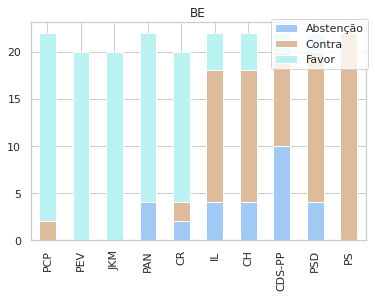

PCP


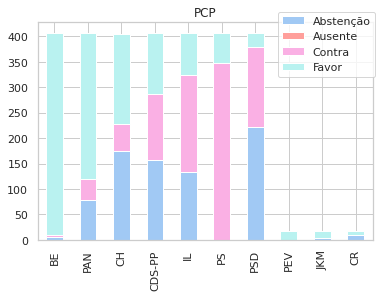

PEV


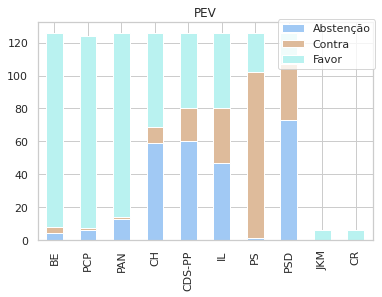

JKM


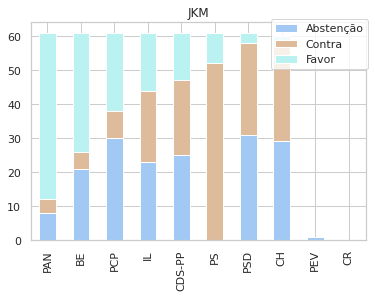

PS


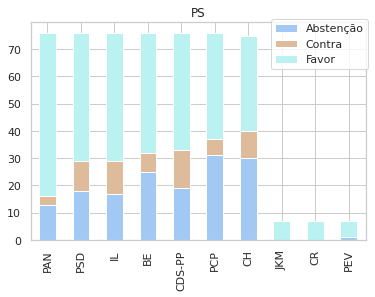

PAN


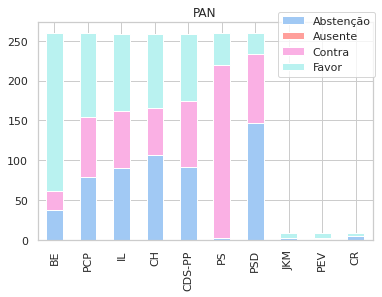

CR


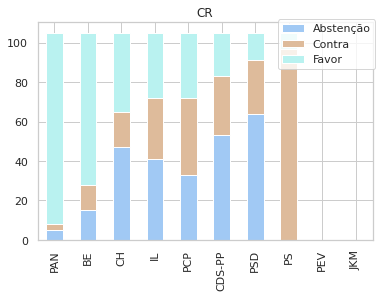

PSD


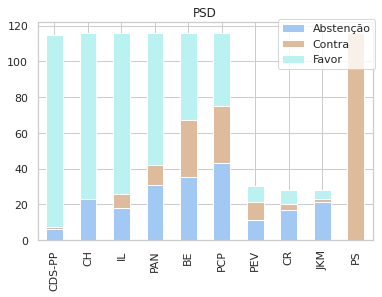

IL


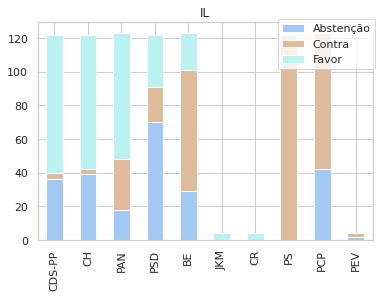

CDS-PP


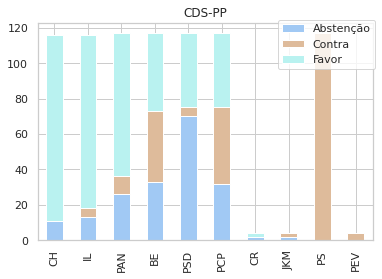

CH


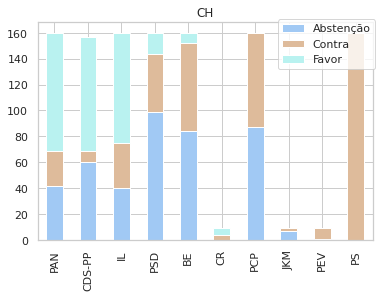

In [14]:
from IPython.display import display
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

ndf = pd.DataFrame()
#submissions_ini_nu = submissions_ini.loc[submissions_ini['unanime'] != "unanime"]
gpsubs = submissions_ini
cmap=ListedColormap(sns.color_palette("pastel").as_hex())

for party in parties:
    print(party)
    sns.set_style("whitegrid")
    subp = gpsubs[gpsubs['GP'] == party]
    sp = subp[parties].apply(pd.Series.value_counts).fillna(0).drop([party],axis=1)
    sp = sp.sort_values(by=['Favor','Abstenção','Contra'], ascending=False, axis=1)
    d = sp.T
    f = plt.figure()
    plt.title(party)
    d.plot(kind='bar', ax=f.gca(), stacked=True, title=party, colormap=cmap)
    plt.legend(loc='center left', bbox_to_anchor=(0.7, 0.9))
    plt.show()


## Dendograma e distância

Com base nas votações obtemos a distância euclideana entre todos os partidos (a distância entre todos os pares possíveis, considerado todas as votações), e com base nela um dendograma que indica a distância entre eles; note-se pelos diagramas acima que o número de votações de PEV. JKM e CR são várias ordens de magnitude inferiores aos restantes. A opção aqui foi removermos estes partidos da análise por considerarmos que o resultado seria muito pouco representativo (e possivelmente enganador) - em todo o caso, é uma opção subjectiva.

In [27]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import numpy as np
votes_hm = oe_dfr[['BE', 'PCP' , 'PS', 'PAN', 'PSD','IL','CDS-PP', 'CH']]
votes_hmn = votes_hm.replace(["Favor", "Contra", "Abstenção", "Ausente"], [1,-1,0,0]).fillna(0)

## Transpose the dataframe used for the heatmap
votes_t = votes_hmn.transpose()

## Determine the Eucledian pairwise distance
## ("euclidean" is actually the default option)
pwdist = pdist(votes_t, metric='euclidean')

## Create a square dataframe with the pairwise distances: the distance matrix
distmat = pd.DataFrame(
    squareform(pwdist), # pass a symmetric distance matrix
    columns = votes_t.index,
    index = votes_t.index
)

## Normalise by scaling between 0-1, using dataframe max value to keep the symmetry.
## This is essentially a cosmetic step to 

distmat_mm=((distmat-distmat.min().min())/(distmat.max().max()-distmat.min().min()))*1

## Affinity matrix
affinmat_mm = pd.DataFrame(1-distmat_mm, distmat.index, distmat.columns)

#pd.DataFrame(distmat_mm, distmat.index, distmat.columns)

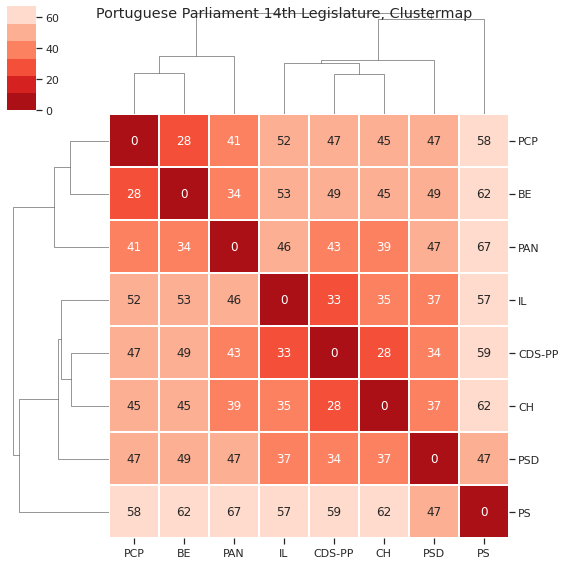

In [28]:
## Perform hierarchical linkage on the distance matrix using Ward's method.
distmat_link = hc.linkage(pwdist, method="ward", optimal_ordering=True )

sns.clustermap(
    distmat,
    annot = True,
    cmap=sns.color_palette("Reds_r"),
    linewidth=1,
    #standard_scale=1,
    row_linkage=distmat_link,
    col_linkage=distmat_link,
    figsize=(8,8)).fig.suptitle('Portuguese Parliament 14th Legislature, Clustermap')

plt.show()

## MDS: *Multidimensional scaling*

Tendo como base os votos no OE podemos utilizar a mesma técnica que empregámos na análise de toda a legislatura: 



Para identificar grupos usamos (mais uma vez, como no trabalho original a que remetemos para todos os detalhes) *Spectrum scaling*, definindo 4 grupos.

In [23]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(4, affinity="precomputed",random_state=2020).fit_predict(affinmat_mm)
sc_dict = dict(zip(distmat,sc))

print(sc_dict)

{'BE': 0, 'PCP': 0, 'PS': 3, 'PAN': 2, 'PSD': 2, 'IL': 2, 'CDS-PP': 1, 'CH': 1}


O resultado aparente resultar numa divisão "esquerda/centro/direita", com o PS numa posição individual; tal como referido não será indiferente o facto do PS ser o partido que suporta o Governo.

Esta separação pode ser vista também em termos de agrupamento e proximidade relativa:

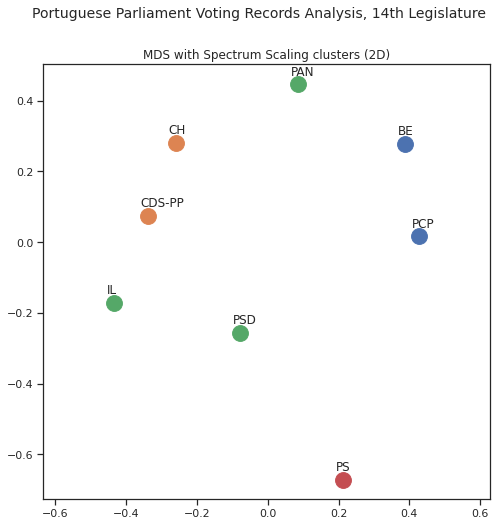

In [24]:
from sklearn.manifold import MDS
import random
mds = MDS(n_components=2, dissimilarity='precomputed',random_state=2020, n_init=100, max_iter=1000)

## We use the normalised distance matrix but results would
## be similar with the original one, just with a different scale/axis
results = mds.fit(distmat_mm.values)
coords = results.embedding_

sns.set()
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle('Portuguese Parliament Voting Records Analysis, 14th Legislature', fontsize=14)
ax.set_title('MDS with Spectrum Scaling clusters (2D)')


for label, x, y in zip(distmat_mm.columns, coords[:, 0], coords[:, 1]):
    ax.scatter(x, y, c = "C"+str(sc_dict[label]), s=250)
    ax.axis('equal')
    ax.annotate(label,xy = (x-0.02, y+0.025))

plt.show()

O resultado aqui quase mapeia a viabilização do OE: o PS enquanto partido de suporte ao Governo, os partidos à sua direita e os à sua esquerda - e o "quase" é exactamente aqui, visto o BE ter votado de forma próxima, nas votações individuais, a partidos que viabilizaram o OE, sem no entanto o ter feito.

Uma visualização em 3D adiciona uma dimensão 

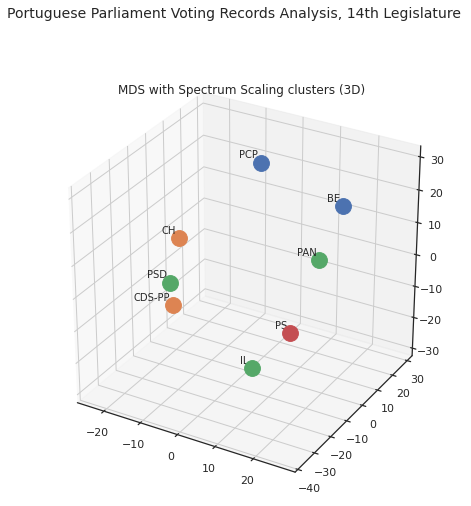

In [21]:
from sklearn.manifold import MDS
import mpl_toolkits.mplot3d
import random

## From https://stackoverflow.com/questions/10374930/matplotlib-annotating-a-3d-scatter-plot
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.text import Annotation

class Annotation3D(Annotation):
    '''Annotate the point xyz with text s'''

    def __init__(self, s, xyz, *args, **kwargs):
        Annotation.__init__(self,s, xy=(0,0), *args, **kwargs)
        self._verts3d = xyz        

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.xy=(xs,ys)
        Annotation.draw(self, renderer)
        
def annotate3D(ax, s, *args, **kwargs):
    '''add anotation text s to to Axes3d ax'''

    tag = Annotation3D(s, *args, **kwargs)
    ax.add_artist(tag)
mds = MDS(n_components=3, dissimilarity='precomputed',random_state=1234, n_init=100, max_iter=1000)
results = mds.fit(distmat.values)
parties = distmat.columns
coords = results.embedding_

sns.set()
sns.set_style("ticks")

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

fig.suptitle('Portuguese Parliament Voting Records Analysis, 14th Legislature', fontsize=14)
ax.set_title('MDS with Spectrum Scaling clusters (3D)')

for label, x, y, z in zip(parties, coords[:, 0], coords[:, 1], coords[:, 2]):
    #print(label,pmds_colors[label])
    ax.scatter(x, y, z, c="C"+str(sc_dict[label]),s=250)
    annotate3D(ax, s=str(label), xyz=[x,y,z], fontsize=10, xytext=(-3,3),
               textcoords='offset points', ha='right',va='bottom')  
plt.show()


## Palavras finais

Esta análise demonstra como a utilização de dados abertos pode, uma vez mais, facilitar a análise da actividade parlamentar por parte dos eleitores; as ilações políticas que se podem tirar são variadas e, se é verdade que existem limitações várias a ter em conta, tal como no trabalho relativo à análise das votações parlamentares parecem emergir padrões que parecem reflectir tendências e agrupamentos que estão presentes no discurso político.

---
***2021, Frederico Muñoz***

## Apêndice
### How to cite this notebook
MUÑOZ, Frederico Serrano - Dados abertos e Ciência de Dados: a aprovação do Orçamento de Estado de 2020 através de dados abertos. [Online] WWW: 